# Cheat Sheet 4

## Exercise 1
In this exercise, you are tasked with implementing a 2-dimensional gradient descent algorithm where the loss function is not explicitly known Our loss function is a black box to us-- we are allowed to hand it some inputs as parameters to an API call, and it sends us back an output, but we are not privy to its internal mechanisms, so we cannot explictly take its gradient.



Let us briefly review gradient descent on a conceptual level. Here is the gist of a 2-d gradient descent algorithm,
1. Specify an initial set of input parameters: 
    - e.g. $(a,b) = (0.5, 0.5)$
2. Caclulate the gradient (i.e. direction of steepest ascent) of the loss function at those input parameters
    - Find the value of $\nabla f(a,b)$
3. Move (a,b) a small step in the opposite direction of the gradient, since this is the direction of steepest descent
    - Replace $(a,b)$ with $(a,b) - \varepsilon \nabla f(a,b)$ for some small positive scalar $\varepsilon$
4. Rinse and repeat steps 2 & 3 until $f(a,b)$ converges.

![Gradient Descent](./Gradient_descent.png)
[image source](https://en.wikipedia.org/wiki/Gradient_descent#/media/File:Gradient_descent.svg)

The only added difficulty we face is in step 2. We need to somehow approximate the gradient based on function values alone. A bit of math should be able to help us in this endeavor. Recall the following formula for the gradient:

$\displaystyle \nabla f(a,b) = \frac{\partial f}{\partial x} (a,b) \hat i + \frac{\partial f}{\partial y} (a,b) \hat j$, where $\hat i$ and $\hat j$ are the unit vectors in the positive $x$ and $y$ directions respectively. 

This formula tells us that the partial derivatives $\displaystyle \frac{\partial f}{\partial x} (a,b)$ and $\displaystyle \frac{\partial f}{\partial x} (a,b)$ in the x and y directions uniquely determine the direction of steepest ascent. These partial derivatives can be computed as follows:

$\displaystyle \frac{\partial f}{\partial x} (a,b) := \lim_{h\to 0} \frac{f(a+h,b) - f(a,b)}{h}$

$\displaystyle \frac{\partial f}{\partial y} (a,b) := \lim_{h\to 0} \frac{f(a,b+h) - f(a,b)}{h}$

Let us focus on the first definition, as the second one follows essentially the same logic.

The numerator of the fraction inside the limit, $\displaystyle f(a+h,b) - f(a,b)$, tells us how much the function $f$ increases or decreases when our input makes small step of size $h$ to the right (in the positive $x$ direction) from our input $(a,b)$. In other words, this is the **rise** as we take a step to the right.

The denominator of that same fraction $h$ is simply the size of the step our input has taken. In other words, this is the **run** of that step to the right. 

As we all learned in basic algebra, slope = rise/run. So the fraction inside the limit is the slope of that small step. As $h\to 0$, our step gets smaller and smaller, so the fraction becomes a better and better approximation of the slope in the $x$ direction at the point $(a,b)$. 

Thus, if we take a suffiently small value of $h$, we get the following approximation:

$\displaystyle \frac{\partial f}{\partial x} (a,b) \approx \frac{f(a+h,b) - f(a,b)}{h}$

By the same reasoning, for a sufficiently small value of $h$, we also get an approximation for the partial derivative in the $y$ direction 

$\displaystyle \frac{\partial f}{\partial y} (a,b) \approx \frac{f(a,b+h) - f(a,b)}{h}$.

Notice that both of these approximations only require us to know a few function values, which we can easily query from the API. Thus we can at last get an approximation of the gradient:

$\displaystyle \nabla f(a,b) \approx \frac{f(a+h,b) - f(a,b)}{h} \hat i + \frac{f(a,b+h) - f(a,b)}{h} \hat j$, for a small value of $h$.

## Exercise 2

In this exercise, we are tasked with modifying Professor McDougal's implementation of the k-means clustering algorithm to work on geographical data (coordinates on a sphere, rather than a plane). Let's start by reviewing his original code to make sense of what's happening at each step.

First, the we import the external tools that we need:

In [1]:
import pandas as pd
import plotnine as p9
import random
import numpy as np

Then we get some data to run our algorithm on and load it into a dataframe:

In [2]:
df = pd.read_csv('https://gist.githubusercontent.com/netj/8836201/raw/iris.csv')

The k-means algorithm works much better if the data is not stretched out in any particular direction, so we write a normalizing function:

In [3]:
def normalize(series):
    return (series - series.mean()) / series.std()

This function moves the series so that it is centered at 0, then scales each value in the series so that its standard deviation is 1.
Using this function, we normalize two series from our dataframe:

In [4]:
df['petal.length.normalized'] = normalize(df['petal.length'])
df['petal.width.normalized'] = normalize(df['petal.width'])

Since we have normalized both of these series, we have effectively centered our dataset at the origin, then squished/stretched it so that it has unit standard deviation both horizontally and vertically.

Our final step in preparation is to specify the inputs and parameters of our algorithm:

In [34]:
k = 3
pts = [np.array(pt) for pt in zip(df['petal.length.normalized'], df['petal.width.normalized'])]

Here, the parameter `k=3` is the number of clusters we have (arbitrarily) chosen to categorize our data into, and the input `pts` is a list of numpy arrays encoding the coordinates for each point.

Now our algorithm begins in earnest. We start by initializing our clusters to have random centers and to contain no points:

In [35]:
centers = random.sample(pts, k)
old_cluster_ids, cluster_ids = None, [] # arbitrary but different

In each run through the following loop, we will iteratively update these clusters by changing the location of their centers. The points will then be reclassified to whichever cluster has the closest center. The algorithm terminates when all the points fail to move between clusters in a single run through the loop:

In [71]:
while cluster_ids != old_cluster_ids: #### change to do while?
    old_cluster_ids = list(cluster_ids)
    cluster_ids = []
    for pt in pts:
        min_cluster = -1
        min_dist = float('inf')
        for i, center in enumerate(centers):
            dist = np.linalg.norm(pt - center)
            if dist < min_dist:
                min_cluster = i
                min_dist = dist
        cluster_ids.append(min_cluster)
    df['cluster'] = cluster_ids
    df['cluster'] = df['cluster'].astype('category')
    cluster_pts = [[pt for pt, cluster in zip(pts, cluster_ids) if cluster == match]
                    for match in range(k)]
    centers = [sum(pts)/len(pts) for pts in cluster_pts]
    (p9.ggplot(df, p9.aes(x="petal.length.normalized", y="petal.width.normalized", color="cluster")) + p9.geom_point()).draw()

Pay special attention to the following block of code:

``` python
for i, center in enumerate(centers):
    dist = np.linalg.norm(pt - center)
    if dist < min_dist:
        min_cluster = i
        min_dist = dist
    cluster_ids.append(min_cluster)
```

In the second line, we are using the euclidian norm of $pt - center$ to determine the distance between that point and that cluster's center. It is precisely this distance function that determines which cluster's center is closest, and therefore which cluster the point will end up in the next run through the loop. This works perfectly well when our points are in euclidian space, as is the case with the above dataset. If, however, our points are in some other type of space, we need to use a different metric to determine the distance between a given point and a given cluster center. In this exercise your data lives on a sphere, so you should use the haversine metric. You can find an implementation of the haversine metric in the accepted answer to this [stack overflow question](https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points).

Also pay attention to the following line of code from the algorithm:

```python
centers = [sum(pts)/len(pts) for pts in cluster_pts]
```

This line of code updates the locations "center" of each cluster to be at the center of mass (or more formally, the centroid) of all that cluster's points. Again, this is applicable in euclidian space, but fails to apply for other types of spaces. To illustrate this, suppose we have 2 points, A & B, on the equator of the earth: one at longitude $160^{\circ}$, and one at longitude $-160^{\circ}$. We would intuitively expect that the "center" between these points will be the midpoint on the shortest between A & B arc $\widehat{AB}$, but the euclidean centroid will give us the point D at $(lat,long)=(0,0)$, on the opposite side of the planet from our intuition.

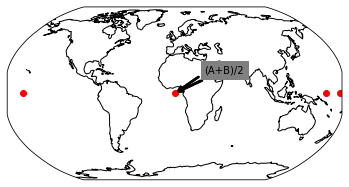

<Figure size 432x288 with 0 Axes>

In [70]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
A = ['A', 0, -160]
B = ['B', 0, 160]
C = ['Center', 0, 175] #should be [0, 180], but plot cuts off at edges
D = ['(A+B)/2', 0, 0]

pt_data = [A, B, C, D]
lats = [pt[1] for pt in pt_data]
lngs = [pt[2] for pt in pt_data]



for name, lng, lat in pt_data:
    plt.plot(lng, lat, marker='o', markersize=7.0, markeredgewidth=2.5,
                 markerfacecolor='red', markeredgecolor='white',
                 transform=ccrs.Robinson())
    at_x, at_y = ax.projection.transform_point(lng, lat, src_crs=ccrs.Robinson())
    plt.annotate(
        name, xy=(at_x, at_y), xytext=(30, 20), textcoords='offset points',
        color='black', backgroundcolor='grey', size='medium',
        arrowprops=dict(arrowstyle='->', color='black', linewidth=2.5))
    at_x, at_y = ax.projection.transform_point(lng, lat, src_crs=ccrs.PlateCarree())
    #ax.annotate(name, xy=(at_x, at_y), transform=ccrs.PlateCarree())
ax.coastlines()
ax.plot(lngs, lats, marker="o", color="red", transform=ccrs.PlateCarree(), linestyle='None')

ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

plt.show()
plt.savefig('euclidean_avg_sphere', format='png')
#fix centroid https://stackoverflow.com/questions/37885798/how-to-calculate-the-midpoint-of-several-geolocations-in-python

How are we to fix this problem? Here's one solution:
1. Embed our points into a unit sphere in 3-dimensional euclidean space using a coordinate transformation, $\displaystyle v = (x,y,z) = T(lat,long)$.
    - $\displaystyle\hat v_i = (x_i, y_i, z_i) = T(lat_i, long_i)$
2. Treat each embedded data point as a vector, pointing from the origin $(0,0,0)$ to that embedded point.
3. Add up all of these vectors using element-wise addition to get some total sum vector, $S$
    - $\displaystyle S = \hat v_1 + \hat v_2 + \ldots + \hat v_n$
    - where the sum of $\displaystyle v = (x, y, z)$ and $\displaystyle u = (a, b, c)$ is given by $\displaystyle v + u = (x+a, y+b, z + c)$
4. Normalize this sum vector by dividing by its euclidean length to get a vector $\displaystyle \hat S$ that lies on the unit sphere:
    - $\displaystyle \hat S = \frac{S}{|S|}$


5. Use the inverse $T^{-1}$ of the coordinate transformation from step 1 to take our normalized vector $\hat S$ back to our original coordinate system:
    - $\displaystyle (lat_{center}, long_{center}) = T^{-1}(\hat S)$

|![Step 3 & 4 gets the center of these embedded points on our sphere in 3d space](./vector_avg.png)| 
|:--:|
|Step 3 & 4 together compute the center of these embedded points on our sphere in 3d space, as seen in this image. [image source](https://www.ffi.no/en/research/n-vector/#example_7)|

The result of this final step gives us the values for the center coordinates in lattitude and longitude, which we can set as the new coordinates for the new center of a cluster in the k-means algorithm. Here's an implementation of this solution in python:

In [3]:
import numpy as np
import numpy.linalg as lin
from math import sin, cos, sqrt, atan2, acos, radians, degrees, pi

In [4]:
#takes 2-d coords as numpy array, returns numpy array representing vector
def T(geocoords):
    #unpack coords from input
    long, lat = geocoords
    
    #convert long and lat to spherical coords
    theta = radians(long)
    phi = pi/2 - radians(lat)
    
    #convert spherical coords to 3-d cartesian coords
    x = sin(phi)*cos(theta)
    y = sin(phi)*sin(theta)
    z = cos(phi)
    
    return np.array([x,y,z])

vT = np.vectorize(T)

In [46]:
T(np.array([0,-90]))

array([ 1.2246468e-16,  0.0000000e+00, -1.0000000e+00])

In [8]:
# takes 3 x 1 numpy array representing unit vector, 
# returns numpy array representing long and lat coords
def inverse_T(vec):
    #unpack coords of input
    x, y, z = vec
    
    theta = atan2(x,y)
    phi = acos(z/sqrt(x * x + y * y + z * z))
    
    long = degrees(theta)
    lat = degrees(pi/2 - phi)
    
    return np.array([long, lat])

# vectorization of inverse T, takes a 3 x n numpy aray representing a list of n unit vectors
# returns 2 x n numpy array representing list of n geocoord pairs
vinverse_T = np.vectorize(inverseT)

In [57]:
inverse_T(np.array([sqrt(2)/2, sqrt(2)/2, 0]))

array([45.,  0.])

In [1]:
# takes a 3 x n numpy array representing a list of our 3d vectors, 
# returns their normalized sum
def cartesian_centroid(vecs):
    summed = np.sum(vecs, axis=0)
    normalized = summed / lin.norm(summed)
    return normalized

In [9]:
# takes a 2 x n numpy array representing a list of our 2d geographical coordinate pairs, returns their centroid as a 2 x 1 numpy array.
def centroid(vecs):
    cart_vecs = vT(vecs)
    cart_center = cartesian_centroid(cart_vecs)
    return inverse_T(cart_center)

In [72]:
vecs = np.array([[0, 0, 1], [1, 0, 0]])
centroid(vecs)

array([0.70710678, 0.        , 0.70710678])

In [9]:
#install cartopy in terminal
!conda install -c conda-forge cartopy -y

Solving environment: \ 
  - anaconda/linux-64::certifi-2021.10.8-py39h06a4308_0
  - defaults/linux-64::certifi-2021.10.8-py39h06a4308done

# All requested packages already installed.



In [10]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

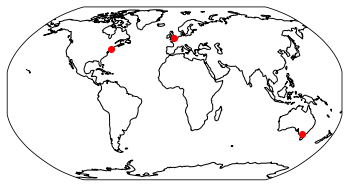

In [11]:

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
yale = [41.3083, -72.9279]
oxford = [51.7520, -1.2577]
melbourne = [-37.8136, 144.9631]
lats = [school[0] for school in [yale, oxford, melbourne]]
lngs = [school[1] for school in [yale, oxford, melbourne]]
ax.coastlines()
ax.plot(lngs, lats, "o", color="red", transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
plt.show()

## Exercise 3

This exercise is relatively straightforward, as long as you know how to use **function decorators.** Let's briefly review these nifty tools:

### What is a function decorator:

Put simply, a function decorator is a tag that we can put on our functions to modify their behavior. Under the hood, a function decorator is itself another function, which takes as an input the function we wish to modify, and outputs the modified version of the function. Python handles this without much help, so unless you're writing your own function decorators, you don't need to think about decorators too hard.

For example, the LRU function decorator will add a cache to any function. Suppose we have a function `fact(n)` that computes the factorial of a natural number, $n$, sometimes written as $n!$

The factorial of a natural number $n$ is just the product of all natural numbers from $1$ to $n$. 

e.g. $5! = 1 \times 2 \times 3 \times 4 \times 5 = 120$.

By convention, we say that $0! = 1$. It is hopefully easy to see that for any natural number $n \geq 1$ the following holds:

$\displaystyle n! = \underbrace{1 \times 2 \times \ldots \times (n-1)}_{(n-1)!} \times n = (n-1)! \times n$.

This property makes the factorial very easy to define recursively, as shown below:

In [14]:
def fact(n):
    if(n > 0):
        return fact(n-1) * n
    else:
        return 1

Now suppose we wanted to print out the first 20 factorial numbers. We might reasonably try the following cell of code:

In [25]:
for i in range(1, 21):
    print(i, '->', fact(i))

1 -> 1
2 -> 2
3 -> 6
4 -> 24
5 -> 120
6 -> 720
7 -> 5040
8 -> 40320
9 -> 362880
10 -> 3628800
11 -> 39916800
12 -> 479001600
13 -> 6227020800
14 -> 87178291200
15 -> 1307674368000
16 -> 20922789888000
17 -> 355687428096000
18 -> 6402373705728000
19 -> 121645100408832000
20 -> 2432902008176640000


This works well enough for small lists but this is extremely inefficient. Manually calculating the value of $i!$ takes $i$ steps. Doing this calculation manually for all the values of $i$ from $1$ to $n$ will then take $ 1 + 2 + \ldots + n = \frac{n(n+1)}{2} = \mathcal{O}(n^2)$ steps.

If however, we have already cached the value of $(i-1)!$, we can retrieve it to calculate $i!$ in just one step. Then calculating the factorial for all values $1, \ldots, n$ will only take $\underbrace{1 +  \ldots + 1}_n = n$ steps. 

This caching can be done easily with the aforementioned LRU function decorator. First we need to import the decorator from python's native functools library:

In [18]:
from functools import lru_cache

Now we simply decorate our factorial function with the lru_cache using the following syntax:

In [19]:
@lru_cache
def lru_fact(n):
    if(n > 0):
        return lru_fact(n-1) * n
    else:
        return 1

Notice that the code for `lru_fact` is almost identical to that of `fact`, with the only differences being that we have changed the name of the function, and that we have added the `@lru_cache` decorator tag above the function declaration.
However the behavior of `lru_fact` is quite different from `fact`. Everytime we call the function, `lru_fac(n)` will first check the cache to see if we've already computed that value. If so, we simply return that cached value. Only if the cache does not contain that value do we manually calculate it. As a sanity check, let's see if we still get the same outputs as before:

In [26]:
for i in range(1, 21):
    print(i,'->', lru_fact(i))

1 -> 1
2 -> 2
3 -> 6
4 -> 24
5 -> 120
6 -> 720
7 -> 5040
8 -> 40320
9 -> 362880
10 -> 3628800
11 -> 39916800
12 -> 479001600
13 -> 6227020800
14 -> 87178291200
15 -> 1307674368000
16 -> 20922789888000
17 -> 355687428096000
18 -> 6402373705728000
19 -> 121645100408832000
20 -> 2432902008176640000


Now that we see the function has the same outputs, let's compare the performance of these two implementations of the factorial function by timing how long it takes to do a big job, like computing 20! a million times. Start by importing the pyton time module.

In [27]:
import time

Now we need to record the time before and after each job:

In [80]:
naive_start = time.time()
for i in range(1_000_000):
    fact(35)
naive_end = time.time()
print(f'The job took {naive_end - naive_start} seconds for the naive factorial function to complete')

The job took 5.121461629867554 seconds for the naive factorial function to complete


In [79]:
cache_start = time.time()
for i in range(1_000_000):
    lru_fact(35)
cache_end = time.time()
print(f'The job took {cache_end - cache_start} seconds for the lru_cache factorial function to complete')

The job took 0.1585378646850586 seconds for the lru_cache factorial function to complete


// write decorator to do timing above

In [ ]:
def time_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        for i in range(1_000_000):
            func(

That's over 25 times faster! For larger values of $n$, the improvements would be even more dramatic.

We can accomplish all kinds of other things with function decorators. For example, there is a library called [Numba](https://numba.pydata.org/) that can speed up numerical calculations by compiling your functions into efficient machine code.

// cache api calls too
// slow down api calls to avoid getting booted

## Exercise 4

In this exercise, you are asked to write a function which implements the Smith-Waterman algoritm, which finds the optimal local aligment of sequences. 
Let us review the algorithm on a conceptual level then do a basic example out by hand so you can get a feel for it.

Recall the dot diagram visualization for comparing two gene sequences.
The basic idea of this diagram is simple.
For two sequences, $s_1$ and $s_2$ of respective length $m$ and $n$, we make an $m$ by $n$ grid of squares. 
If the $i^{th}$ letter of $s_1$ and the $j^{th}$ letter of $s_2$ match, then we fill in the square with $i$ down and $j$ to the right from the top left corner. Otherwise, we leave that square blank.
|Dot Diagram Example|
|---|
|![Small Dot Diagram](./dot_diagram.png)|

If you stare long enough, you'll realize that matching subsequences correspond to diagonal lines running from the the upper left to the lower right on the diagram. 
Why is that? 
Moving down one square corresponds to moving forward one letter in sequence $s_1$.
Moving right one square corresponds to moving forward one letter in sequence $s_2$.
Therefore moving down and to the right corresponds to moving forward one letter in both sequences.
Thus moving down and to the right several times in a row and finding a black square each time just means we are moving forward in each sequence multiple times and finding a match each time.
Thus, finding the longest matching subsequences of $s_1$ and $s_2$ is as simple as finding the longest diagonal line on the dot diagram.


That's all fine and good, but there are several challenges we encounter when applying this technique in the real world.
For one thing, since the sequences we care about are genetic sequences derived from the real world, they tend to mutate.
Mutations can happen in multiple different ways.
1. Insertion - one or more random letter is added somewhere in the middle of a sequence
    - e.g. AGCT becomes AG**T**CT
2. Deletion - one or more random letters is removed somewhere in one of a sequence
    - e.g. AG**C**T becomes AGT
3. Base substitutions - one or more letters get swapped out for other letters, but the length of the sequence does not change
    - e.g. AG**C**T becomes AG**A**T 



We may still be interested in finding almost-matching subsequences since they still tell us valuable information about the sequences we are comparing.
How can we adapt our technique to handle these new mutations in order to find almost-matching subsequences?
Insertion and deletion can result in either horizontal or vertical gaps that separate two diagonal lines on the diagram.
Base substitutions can result in a diagonal line that has some missing (white) squares in the middle.

Aside from mutations, we face another challenge when it comes to real world data: volume.
The above dot diagram is just 18 by 21 in size, so our eye can pick out the longest matching subsequence in just a few tries.
With a bit more effort we can pick out some long almost-matching subsequences.
But what if we made our diagram based on some longer sequences?
|Larger Dot Diagram Example|
|--|
|![Large Dot Diagram](./large_dot_diagram.png)|



It's already nearly impossible to eyeball the problem from this diagram, and each of these sequences is just a few hundred letters long.
The average human gene is several thousand base-pairs long, and the human genome is about 6.4 billion base-pairs long.
Thus, we arrive at the need to have an algorithm automate the eyeball work. 
This is essentially the goal that the Smith-Waterman algorithm aims to achieve using dynamic programming.

Much like the dot diagram method, Smith-Waterman starts by creating a regtangular grid, where the x and y coordinates of a square in the grid correspond to indices in our two sequences.
This grid contains numerical values which keep a running score of how good our matching subsequences are. 
The longer a matching subsequence is, the better its score.
We'd also like to penalize almost-matching subsequences for every mutation they contain.



Thus our algorithm has three parameters: 
1. match - the score we add to the total for each matching term in the sequence.
2. gap_penalty - the score we subtract from the total for each horizontal or vertical gap in the subsequence corresponding to an insertion or deletion mutation.
3. mismatch_penalty - the score we subtract from the total for each mismatching term in the subsequence.



#### Example

In this example, we'll choose match = gap_penalty = mismatch_penalty = 1.
We'll start by initializing each score in the grid to zero, and then update these scores working from the top-left corner and working downwards and to the right.
For illustration purposes, we'll show this numerical grid overlaid on a dot-diagram.

| Initializing Score Grid to Zero|
|---|
|![initializing grid](./illustrations/initializing_grid.png)|

Notice that there is one extra row at the top and one extra column on the left.
This is because at every step in the algorithm, we rely on values above and to the left to determine the score for our current cell.
Now that we've initialized the grid, it's time to start updating values:

![](illustrations/matrix-filling-(1%2C%201).png) 

The current cell can take one of four values. 
1. We can take the upper left value ($ul=0$) plus match ($=1$) for a total of $1$, 
2. We can take the left value ($l=0$) minus the gap penalty ($=1$) for a total of $-1$, 
3. We can take the upper value ($u=0$) minus the gap penalty for a total of $-1$. 
4. 0

Of the four possibilities, the first is the largest, so $1$ is the current cell's new value.



![](./illustrations/matrix-filling-(1%2C%202).png)

Moving on, the current cell can take one of four values: 
1. $ul -$ mismatch_penalty $= 0 - 1 = -1$
2. $l -$ gap_penalty $= 1 - 1 = 0$
3. $u -$ gap_penalty $= 0 - 1 = -1$
4. 0

0 is the largest of these possibilities, so the new value for the current cell is 0.

![ ](./illustrations/matrix-filling-(1%2C%203).png)

The current cell can take on one of three values:
1. $ul -$ mismatch_penalty $= 0 - 1 = -1$
2. $l -$ gap_penalty $= 0 - 1 = -1$
3. $u -$ gap_penalty $= 0 - 1 = -1$
4. 0

The first 3 values are negative, so our new cell gets a value of zero

We continue in this way until the whole grid fills up, which should give us the following scores:

![](./illustrations/matrix-filling-(6%2C%206).png))


**NOTE:** When you're implementing the first half of this algorithm, you want to keep track of which square has the largest score you've seen so far, and update that value everytime you see a new max score.
That way, you don't have to scan through the whole grid again to start find the maximum.


We can see that the square in the second to last row and the last column has the largest value, so we'll start the backtracking portion of the algorithm from that square.

![](./illustrations/backtracking-(5%2C%206).png) 



Starting from this square, we add the corresponding sequence element to each of our match sequence outputs.

|`match_seq1 = "C"`|
|---|
| `match_seq2 = "C"`|

That is match_sequence_1 and match_sequence_2 both end with C.
Then we check to see if square up and to the left is a match. 
We see that the upper left square is a match because the upper left value is our current cell's value minus match

- $ul = current - match$

Thus we shift up and to the right for the next step.

![](./illustrations/backtracking-(4%2C%205).png)


This square is also a match, so we add the corresponding sequence element "A" to the **beginning** of both match sequences. 

|`match_seq1 = "AC"`|
|---|
|`match_seq2 = "AC"`|

From this square we still see that $ul = current - match$ so we can move up and to the left.



![](./illustrations/backtracking-(3%2C%204).png)



This is our first non-matching square, so it requires some additional logic.
We see that both of the following are true:

1. $ current = ul - mismatch $
2. $ current = l - gap $

This means that we have two different ways that our match sequences could be constructed. 
For this exercise, you are tasked only with constructing a single pair of match sequences, so it's time to make an arbitrary choice about whether we give gaps or mismatches priorities.
Here, I will prioritize gaps, but you could choose whatever you like.

Since I'm choosing a gap, our cursor will move up and to the left in the next step, but first we have to figure out how to update our match sequences.
Since the cursor is going to move horizontally, this step corresponds to a gap in the vertical sequence (match_sequence 1).
Thus, we add "-" to the beginning of match sequence 1, and "G" to the beginning of match_sequence_2.

|`match_seq1 = "-AC"`|
|---|
| `match_seq2 = "GAC"`|




![](./illustrations/backtracking-(3%2C%203).png)

From here on out, all the remaining squares are matches, so we always go up and to the left, each time, prepending the corresponding sequence element to our match sequences:

|`match_seq1 = "T-AC"`|
|---|
| `match_seq2 = "TGAC"`|


|![](./illustrations/backtracking-(2%2C%202).png)|
|---|
|`match_seq1 = "TT-AC"`|
| `match_seq2 = "TTGAC"`|


|![](./illustrations/backtracking-(1%2C%201).png)|
|---|
|`match_seq1 = "GTT-AC"`|
| `match_seq2 = "GTTGAC"`|

At last, we have arrived at the final square, and thus our final output for the algorithm. In this implementation, you will return a 3-tuple: (match_seq1, match_seq2, score), where score is the maximum score on the whole grid.

**NOTE** There is another way of implementing the algorithm that involves keeping track of how each square got its score by storing a second grid of pointers that are updated during the first half of the program: 

![](./illustrations_alt/backtracking-(5%2C%206).png)

While this does make the backtracking easier to code, it also doubles the memory the algorithm uses, so it is not advisable for large grids.